In [ ]:
from PIL import Image

In [ ]:
threads_per_block = 16

In [ ]:
from google.colab import files

def upload_img(path):
  return Image.open("/content/" + path)

In [ ]:
def perform_BI_CPU(arr):
  for i in range(len(arr)):
    for j in range(0, len(arr[i]) * 2, 2):
      arr[i].insert(j, arr[i][j])

  for i in range(0, len(arr) * 2, 2):
    arr.insert(i, arr[i])

In [ ]:
from numba import cuda

@cuda.jit
def perform_BI_GPU(arr, result):
  idx = cuda.threadIdx.x + cuda.blockDim.x * threads_per_block

  cuda.syncthreads()

  if idx < result.shape[0]:
    for j in range(result.shape[1]):
      for k in range(3):
        result[idx * 2][j * 2][k] = arr[idx][j][k]
        result[idx * 2][j * 2 + 1][k] = arr[idx][j][k]
        result[idx * 2 + 1][j * 2][k] = arr[idx][j][k]
        result[idx * 2 + 1][j * 2 + 1][k] = arr[idx][j][k]

In [ ]:
def process_and_show_img_from_list(img_list):
  img_array = np.array(img_list).astype(np.uint8)

  processed_img = Image.fromarray(img_array, 'RGB')
  display(processed_img)

In [ ]:
def process_and_show_img_from_array(img_array):
  img_array = img_array.astype(np.uint8)

  processed_img = Image.fromarray(img_array, 'RGB')
  display(processed_img)

In [ ]:
from time import time
import numpy as np

def perform_bilinear_interpolation(img):

  print("\n_________________________________________________________________________________________")
  print("CPU calculation: ")

  img_array_cpu = np.asarray(img)
  img_list_cpu = img_array_cpu.tolist()

  start_time = time()
  perform_BI_CPU(img_list_cpu)
  result_time = time() - start_time

  print("\nCPU time: ", result_time, "\n")

  print("\nCPU result image: \n")
  process_and_show_img_from_list(img_list_cpu)

  
  print("\n_________________________________________________________________________________________")
  print("GPU calculation: ")

  img_array_gpu = np.asarray(img)
  img_list_gpu = img_array_gpu.tolist()

  result = np.zeros([len(img_list_gpu) * 2, len(img_list_gpu[0]) * 2, len(img_list_gpu[0][0])], dtype = int)

  start_time = time()
  perform_BI_GPU[len(img_list_gpu) // threads_per_block + 1, threads_per_block](img_array_gpu, result)
  result_time = time() - start_time

  print("\nGPU time: ", result_time, "\n")

  print("\nGPU result image: \n")
  process_and_show_img_from_array(result)

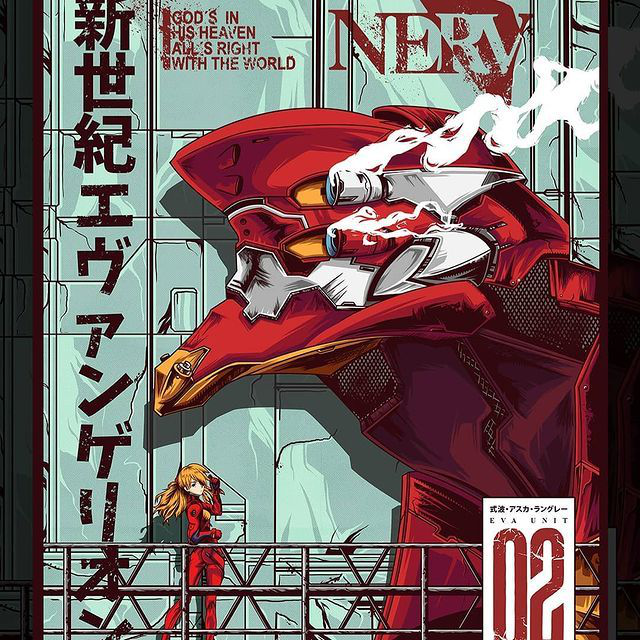


_________________________________________________________________________________________
CPU calculation: 

CPU time:  0.14661884307861328 


CPU result image: 



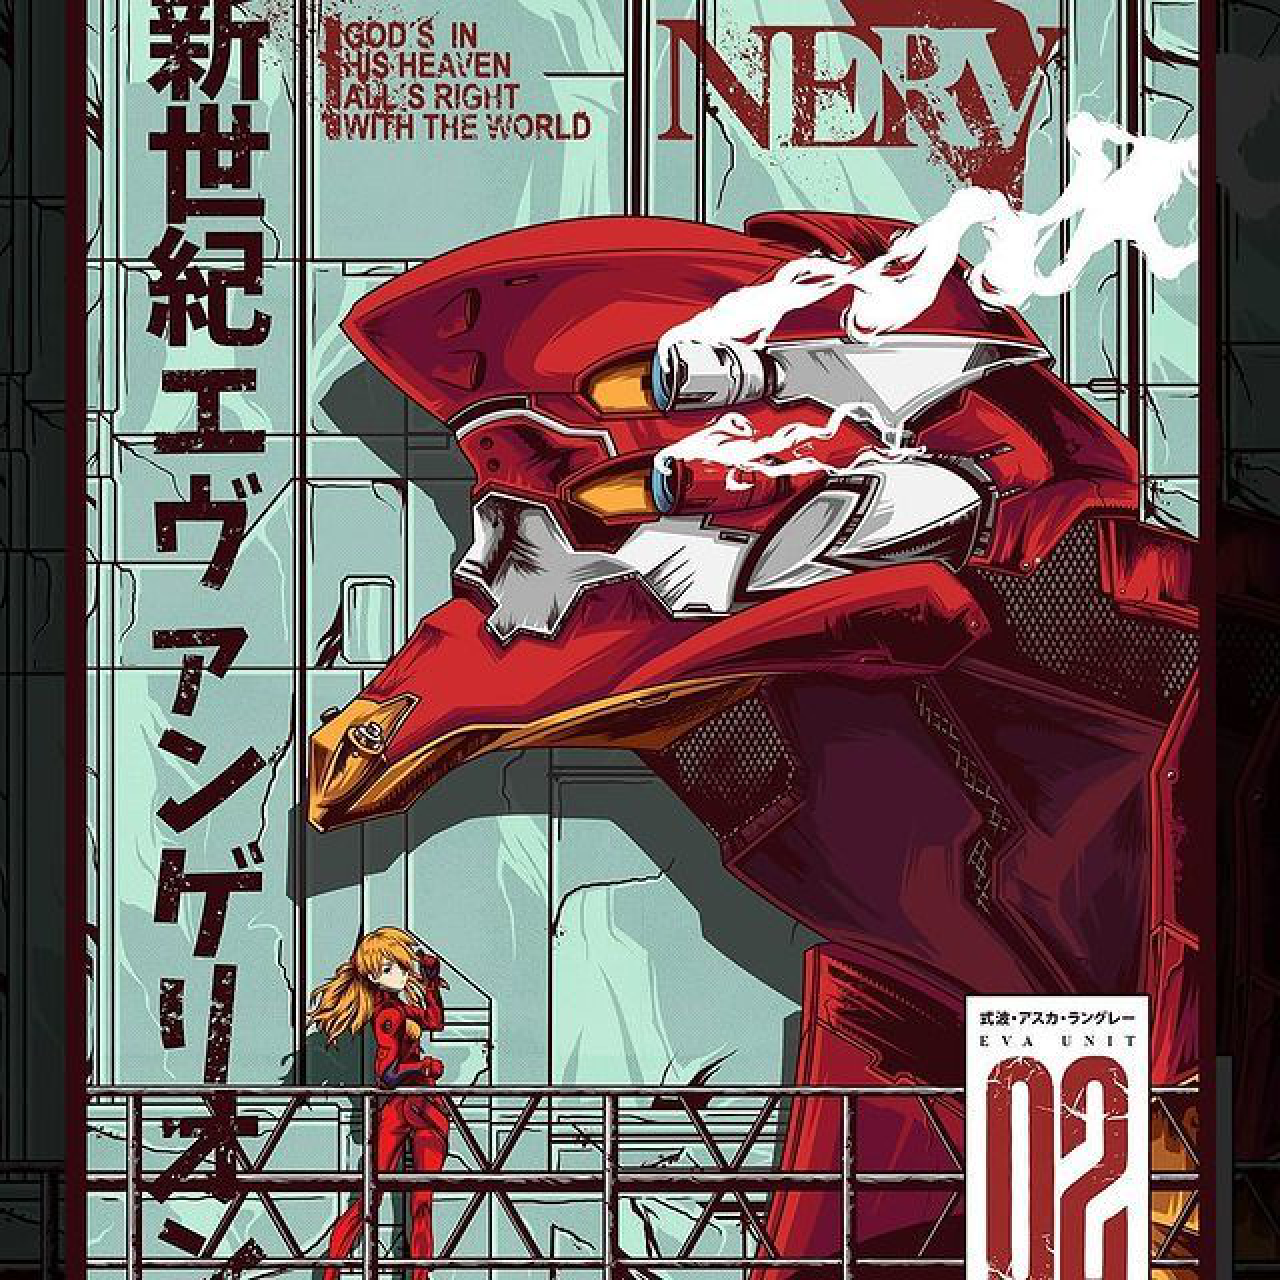


_________________________________________________________________________________________
GPU calculation: 


ERROR:numba.cuda.cudadrv.driver:Call to cuMemcpyHtoD results in UNKNOWN_CUDA_ERROR


CudaAPIError: ignored

In [ ]:
if __name__ == "__main__":
  path = "img_to_upload.jpg"

  img = upload_img(path)
  display(img)

  perform_bilinear_interpolation(img)